# ニュートン法と最急降下法の比較
今回は、ニュートン法を用いた関数の最適化を行い、最急降下法との収束性の比較をしてみましょう。
まず、最急降下法およびニュートン法のアルゴリズムをそれぞれ実装し、その後教科書(福島 2011) の例(式4.19) に関して生成点列の挙動の確認を、その後、前回扱った関数についても同様に生成点列の挙動の確認をしてみましょう。

## 最急降下法
比較のために、まずは与えられた初期点をもとに、最急降下法による点列の生成を行う関数`sdm` を実装しましょう。
目的関数`fun`、その勾配`jac`、および目的関数のヘッセ行列`hess` は、それぞれPython 上の関数として与えられるもの(後に用意するもの)とします。
ここでは、反復回数は15 回としました。

In [1]:
import numpy as np
from scipy.optimize import line_search

def sdm(xk, iter=15):
    sequence = [xk]
    for k in range(iter):
        dk = -jac(xk)
        alpha = line_search(fun, jac, xk, dk)[0]
        xk = xk + alpha * dk
        sequence.append(xk)
    return np.array(sequence)

## ニュートン法
続いて、与えられた初期点をもとに、ニュートン法による点列の生成を行う関数`newton` を実装しましょう。
最急降下法と同様に、反復回数は15 回とします。
ニュートン法は、教科書(福島 2011) にある通り、

0. $x^{(0)}\in\mathbb{R}^n$, $k:=0$.
1. $d^{(k)}:=-\nabla^2f(x^{(k)})\nabla f(x^{(k)})$.
2. $x^{(k+1)}:=x^{(k)}+d^{(k)}$, $k:=k+1$. goto 1.

のステップを反復します。
ここでは、このプログラムをそのまま書き起こしてみましょう。

In [2]:
import numpy as np
from scipy.optimize import line_search

def newton(xk, iter=15):
    sequence = [xk]
    for k in range(iter):
        dk = np.linalg.solve(hess(xk), -jac(xk))
        xk = xk + dk
        sequence.append(xk)
    return np.array(sequence)

## 教科書の例での生成点列の挙動
### 目的関数、勾配、ヘッセ行列の実装
まずは、教科書(福島 2011) の例(式4.19)、
\begin{align*}
f(x)=(x_0-1)^2+10(x_0^2-x_1)^2
\end{align*}
に対して、最急降下法とニュートン法をそれぞれ適用し、その生成点列の挙動を確認してみましょう。
目的関数を`fun`、その勾配を`jac`、そして目的関数のヘッセ行列を`hess` として、それぞれPython 上の関数として、それぞれ実装します。

In [3]:
import numpy as np

def fun(x):
    return (x[0] - 1) ** 2 + 10 * (x[0] ** 2 - x[1]) ** 2

def jac(x):
    return np.array([2 * (x[0] - 1) + 40 * (x[0] ** 3 - x[0] * x[1]), -20 * (x[0] ** 2 - x[1])])

def hess(x):
    return np.array([[120 * (x[0] ** 2) - 40 * x[1] + 2, -40 * x[0]],
                      [-40 * x[0], 20]])

### 生成点列の観察と比較
それでは、原点$(0, 0)^\top$ を初期点に、最急降下法(SDM) とニュートン法(Newton) のそれぞれが生成する点列を観察してみましょう。

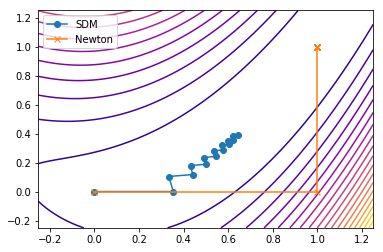

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
X, Y = np.meshgrid(np.linspace(-0.25, 1.25, 100), np.linspace(-0.25, 1.25, 100))
Z = np.array([[fun(np.array([x, y])) for x, y in zip(vx, vy)] for vx, vy in zip(X, Y)])
plt.contour(X, Y, Z, cmap='plasma', levels=np.linspace(np.min(Z), np.max(Z), 20))
sequence = sdm(np.array([0., 0.]))
plt.plot(sequence[:, 0], sequence[:, 1], marker='o', label='SDM')
sequence = newton(np.array([0., 0.]))
plt.plot(sequence[:, 0], sequence[:, 1], marker='x', label='Newton')
plt.legend()

最急降下法が小刻みに振動しながら解を更新しているのに対し、Newton 法は極めて効率よく、2 回ほどの反復でほぼ最適解の$(1, 1)^\top$ 付近に到達していることが分かります。
したがって、この例では、Newton 法は最急降下法と比較して、比べ物にならないくらい効率的な挙動をすることが分かります。
しかし、Newton 法を用いれば、常に最急降下法よりも効率的に最適解を求めることができるのでしょうか・・・？

## 前回の例での生成点列の挙動
続いて、前回例として用いた２変数関数、
\begin{align*}
f(x_0, x_1):=\sin\left(\frac{1}{2}x_0^2-\frac{1}{4}x_1^2+3\right)\cos(2x_0+1-e^{x_1})
\end{align*}
を目的関数として考えましょう。
この関数は、前回確認した通り、下記のような複雑な形状をしていました。

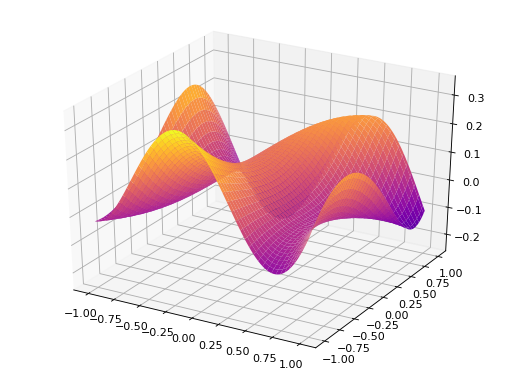

In [5]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8, 6), dpi=80)
ax = plt.axes(projection='3d')
X, Y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
Z = np.array([[np.sin((x ** 2) / 2 - (y ** 2 ) / 4 + 3) * np.cos(2 * x + 1 - np.exp(y)) for x, y in zip(vx, vy)] for vx, vy in zip(X, Y)])
ax.plot_surface(X, Y, Z, cmap='plasma')

### 目的関数、勾配、ヘッセ行列の実装
先程と同様に、目的関数を`fun`、その勾配を`jac`、そして目的関数のヘッセ行列を`hess` として、それぞれPython 上の関数として実装しましょう。
なお、数式の微分については、Anaconda に標準で含まれている[SymPy](https://www.sympy.org/en/index.html) という機能を用いてコンピュータに自動で計算させることができます。
(記号微分: 我々が普段微分の計算を行うときと同じように、パターンを置き換えて数式を微分する計算法)
ここでは詳細な説明は省きますが、下記が関数`F` とその各偏微分をSymPy を用いて計算するプログラムです。

In [6]:
import numpy as np
from sympy import symbols, sin, cos, exp, diff

_x, _y = symbols('x, y')
F = sin((_x ** 2) / 2 - (_y ** 2) / 4 + 3) * cos(2 * _x + 1 - exp(_y))
FdX, FdY = diff(F, _x), diff(F, _y)
FdXdX, FdXdY = diff(FdX, _x), diff(FdX, _y)
FdYdX, FdYdY = diff(FdY, _x), diff(FdY, _y)

def fun(x):
    p = {_x: x[0], _y: x[1]}
    return float(F.subs(p))

def jac(x):
    p = {_x: x[0], _y: x[1]}
    return np.array([FdX.subs(p), FdY.subs(p)], dtype=np.float)

def hess(x):
    p = {_x: x[0], _y: x[1]}
    return np.array([[FdXdX.subs(p), FdXdY.subs(p)],
                      [FdYdX.subs(p), FdYdY.subs(p)]], dtype=np.float)

### 生成点列の観察と比較 (ニュートン法が収束する例)
それでは、最急降下法により生成した点列と、ニュートン法で生成した点列の、それぞれの挙動を、目的関数に関する等高線グラフの上に描画し、確認してみましょう。
まずは、初期点$x^{(0)}:=(-0.75, -0.25)^\top$ (解の十分近く) とした例です。

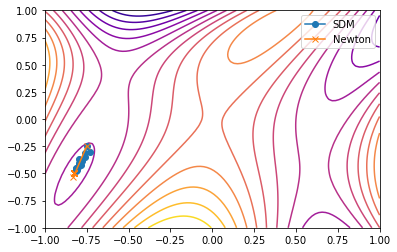

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
X, Y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
plt.ylim(-1, 1)
plt.xlim(-1, 1)
Z = np.array([[np.sin((x ** 2) / 2 - (y ** 2 ) / 4 + 3) * np.cos(2 * x + 1 - np.exp(y)) for x, y in zip(vx, vy)] for vx, vy in zip(X, Y)])
plt.contour(X, Y, Z, cmap='plasma', levels=np.linspace(np.min(Z), np.max(Z), 15))
sequence = sdm(np.array([-0.75, -0.25]))
plt.plot(sequence[:, 0], sequence[:, 1], marker='o', label='SDM')
sequence = newton(np.array([-0.75, -0.25]))
plt.plot(sequence[:, 0], sequence[:, 1], marker='x', label='Newton')
plt.legend()

この場合、細かな解の更新を繰り返す最急降下法に比べて、ニュートン法はかなり効率的に解を更新していることがわかります。

### 生成点列の観察と比較 (ニュートン法が収束しない例)
では、前回と同様、初期点$(-0.3, 0.2)^\top$ を与えた場合はどうなるのでしょうか？

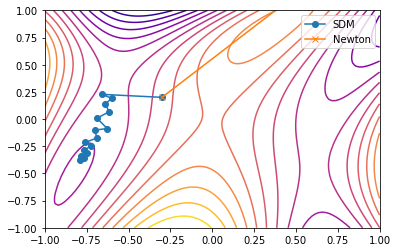

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
X, Y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
plt.ylim(-1, 1)
plt.xlim(-1, 1)
Z = np.array([[np.sin((x ** 2) / 2 - (y ** 2 ) / 4 + 3) * np.cos(2 * x + 1 - np.exp(y)) for x, y in zip(vx, vy)] for vx, vy in zip(X, Y)])
plt.contour(X, Y, Z, cmap='plasma', levels=np.linspace(np.min(Z), np.max(Z), 15))
sequence = sdm(np.array([-0.3, 0.2]))
plt.plot(sequence[:, 0], sequence[:, 1], marker='o', label='SDM')
sequence = newton(np.array([-0.3, 0.2]))
plt.plot(sequence[:, 0], sequence[:, 1], marker='x', label='Newton')
plt.legend()

なんと、Newton 法で生成した点列は、画面の外(右上方向; 関数値が上がる方向) に吹き飛んでいることがわかります。
しかし最急降下法は、振動し効率が悪くはありますが、着実に最適解の方向へ点列を更新しています。

## 信頼領域法
Newton 法のような効率の良さと、最急降下法のような着実な収束性の両方を獲得するためにはどうすればよいのでしょうか？
ここでは、信頼領域法と呼ばれる最適化アルゴリズムの一種、`trust-exact` アルゴリズムを用いた最適化を行ってみましょう。
`trust-exact` アルゴリズムは、Anaconda に標準で付属しているSciPy に実装されており、
```python
from scipy.optimize import minimize
x = minimize(fun, x0, method='trust-exact', jac=jac, hess=hess).x
```
で、最適解`x` を求めることができます。
ここで、`fun` は目的関数、`jac` はその勾配、また`hess` は目的関数のヘッセ行列を求めるPython 関数とします。
それでは、最急降下法、ニュートン法、信頼領域法(`trust-exact`) の生成点列をそれぞれ求めて比較してみましょう。

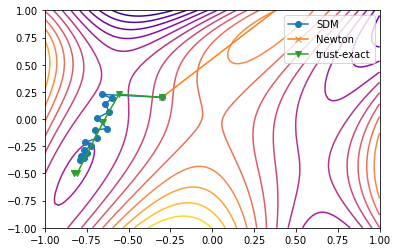

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.optimize import minimize
X, Y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
plt.ylim(-1, 1)
plt.xlim(-1, 1)
Z = np.array([[np.sin((x ** 2) / 2 - (y ** 2 ) / 4 + 3) * np.cos(2 * x + 1 - np.exp(y)) for x, y in zip(vx, vy)] for vx, vy in zip(X, Y)])
plt.contour(X, Y, Z, cmap='plasma', levels=np.linspace(np.min(Z), np.max(Z), 15))
sequence = sdm(np.array([-0.3, 0.2]))
plt.plot(sequence[:, 0], sequence[:, 1], marker='o', label='SDM')
sequence = newton(np.array([-0.3, 0.2]))
plt.plot(sequence[:, 0], sequence[:, 1], marker='x', label='Newton')
sequence = [np.array([-0.3, 0.2])]
minimize(fun, sequence[0], method='trust-exact', jac=jac, hess=hess, callback=lambda xk: sequence.append(xk))
sequence = np.array(sequence)
plt.plot(sequence[:, 0], sequence[:, 1], marker='v', label='trust-exact')
plt.legend()

結果から分かるように、信頼領域法(`trust-exact`) は、最急降下法と同様の最適解へ収束しますが、しかし最急降下法のように振動せず、かなり効率的に収束していることが分かります。

## 参考文献
  * 福島雅夫著『新版　数理計画入門』(朝倉書店; 2011)
  * 矢部博著『工学基礎　最適化とその応用』(数理工学社; 2006)
  * [Gradient descent - Wikipedia](https://en.wikipedia.org/wiki/Gradient_descent) (目的関数はこのページのものを使用しました。)